In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hotel_booking.csv')

# Display the first 5 rows of the DataFrame
#print(df.head())

In [ ]:
#define function to swap columns
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

#swap points and rebounds columns
#df = swap_columns(df, 'hotel', 'is_canceled')

from IPython.display import display
display(df.head())

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.00,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.00,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.00,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.00,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.00,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,Transient,96.14,0,0,Check-Out,2017-09-06,Claudia Johnson,Claudia.J@yahoo.com,403-092-5582,************8647
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,Transient,225.43,0,2,Check-Out,2017-09-07,Wesley Aguilar,WAguilar@xfinity.com,238-763-0612,************4333
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,Transient,157.71,0,4,Check-Out,2017-09-07,Mary Morales,Mary_Morales@hotmail.com,395-518-4100,************1821
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,Transient,104.40,0,0,Check-Out,2017-09-07,Caroline Conley MD,MD_Caroline@comcast.net,531-528-1017,************7860


In [ ]:
month_map = {'January':'01', 'February':'02', 'March':'03', 'April':'04', 'May':'05', 'June':'06', 'July':'07', 'August':'08', 'September':'09', 'October':'10', 'November':'11', 'December':'12'}
df.arrival_date_month = df.arrival_date_month.map(month_map).astype(int)

In [ ]:
#df.add('arrival_date')
df['arrival_date'] = df['arrival_date_year'].astype(str)+'-'+df['arrival_date_month'].astype(str)+'-'+df['arrival_date_day_of_month'].astype(str)

In [ ]:
def roomChange(row):
    if row['assigned_room_type'] == row['reserved_room_type']:
        return False
    else:
        return True

df['change_in_room'] = df.apply(roomChange, axis=1)

In [ ]:
df['total_bookings'] = df['previous_cancellations'] + df['previous_bookings_not_canceled']

In [ ]:
#Replace Nans with zeros
for i in df.columns:
  df[i].fillna(df[i].mode()[0], inplace=True)

In [ ]:
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])
df['arrival_date'] = pd.to_datetime(df['arrival_date'])

In [ ]:
for i in range(len(df)):
    if df.loc[i, 'country'] == 'USA':
        df.at[i, 'country'] = 1
    else:
        df.at[i, 'country'] = 0

In [ ]:
df['stay_duration'] = df['reservation_status_date'] - df['arrival_date']
df['stay_duration'] = df['stay_duration'] / np.timedelta64(1, 'D')
df['stay_duration'] = df['stay_duration'].astype(int)

In [ ]:
for i in range(len(df)):
    if df.loc[i, 'stay_duration']<0:
        df.at[i, 'stay_duration'] = -1

In [ ]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
var = ['hotel', 'customer_type', 'deposit_type', 'change_in_room', 'market_segment', 'distribution_channel', 'country']
for item in var:
    df[item] = lb.fit_transform(df[item])
df = pd.get_dummies(df, columns=['hotel', 'customer_type', 'deposit_type', 'change_in_room', 'market_segment', 'distribution_channel', 'country'])

In [ ]:
df.drop(['meal', 'assigned_room_type', 'reserved_room_type', 'reservation_status', 'reservation_status_date', 'arrival_date', 'name', 'email', 'phone-number', 'credit_card'], axis=1, inplace=True)

In [ ]:
train_var = df.drop(['is_canceled'], axis=1)
test_var = df['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(train_var, test_var, test_size=0.20, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((95512, 48), (95512,), (23878, 48), (23878,))

In [ ]:
from sklearn.preprocessing import MinMaxScaler
#Data scaling
std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)

mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train)
X_train_mm = mm_scaler.transform(X_train)
X_test_mm = mm_scaler.transform(X_test)

In [ ]:
display(df.head())

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,market_segment_5,market_segment_6,market_segment_7,distribution_channel_0,distribution_channel_1,distribution_channel_2,distribution_channel_3,distribution_channel_4,country_0,country_1
0,0,342,2015,7,27,1,0,0,2,0.0,...,0,0,0,0,1,0,0,0,1,0
1,0,737,2015,7,27,1,0,0,2,0.0,...,0,0,0,0,1,0,0,0,1,0
2,0,7,2015,7,27,1,0,1,1,0.0,...,0,0,0,0,1,0,0,0,1,0
3,0,13,2015,7,27,1,0,1,1,0.0,...,0,0,0,1,0,0,0,0,1,0
4,0,14,2015,7,27,1,0,2,2,0.0,...,0,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,23,2017,8,35,30,2,5,2,0.0,...,1,0,0,0,0,0,1,0,1,0
119386,0,102,2017,8,35,31,2,5,3,0.0,...,0,1,0,0,0,0,1,0,1,0
119387,0,34,2017,8,35,31,2,5,2,0.0,...,0,1,0,0,0,0,1,0,1,0
119388,0,109,2017,8,35,31,2,5,2,0.0,...,0,1,0,0,0,0,1,0,1,0


In [ ]:
np.any(np.isnan(df))

False

In [ ]:
def get_confusion_matrix(cnf_matrix):
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

def get_results(Y_test, Y_pred):
    print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))
    print("Precision:",metrics.precision_score(Y_test, Y_pred))
    print("Recall:",metrics.recall_score(Y_test, Y_pred))
    print("F1-Score:",metrics.f1_score(Y_test, Y_pred))

Accuracy: 0.9922522824357148
Precision: 0.9984116178806445
Recall: 0.980938579868465
F1-Score: 0.9895979758223221


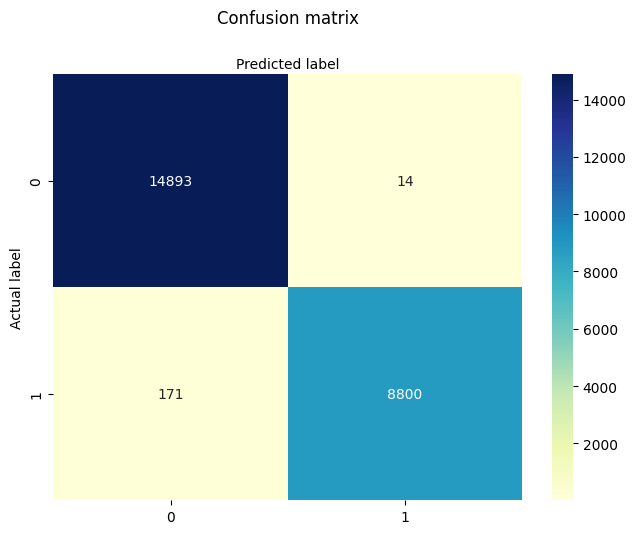

In [ ]:
from sklearn.model_selection import cross_val_score
#Logistic Regression
logreg = LogisticRegression(max_iter=500).fit(X_train_mm, y_train)
scores = cross_val_score(logreg, X_train_mm, y_train, cv=5)
logreg_pred = logreg.predict(X_test_mm)

get_results(y_test, logreg_pred)
get_confusion_matrix(confusion_matrix(y_test, logreg_pred))

Accuracy: 0.9993718066839768
Precision: 0.9987747828024058
Recall: 0.9995541188273325
F1-Score: 0.9991642988467324


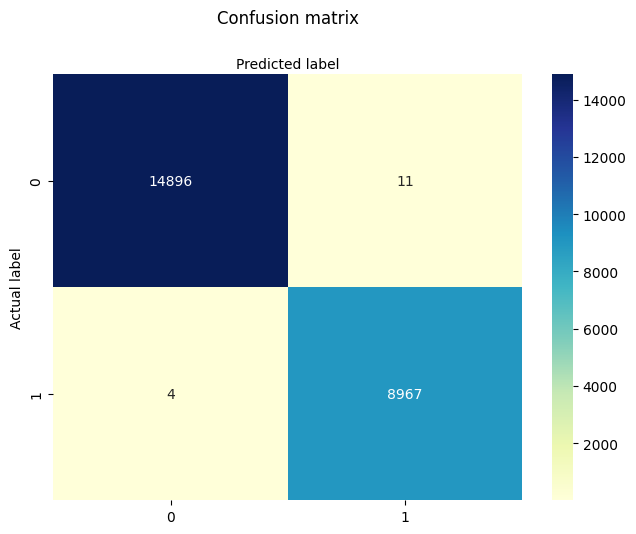

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=[35, 20], alpha=0.001, solver='adam', activation='relu')
mlp.fit(X_train_std, y_train)
mlp_pred = mlp.predict(X_test_std)
#print("Train score: {:.3f}".format(mlp.score(X_train_std, y_train)))
#print("Test accuracy: {:.3f}".format(mlp.score(X_test_std, y_test)))
#print("F1 score: {:.3f}".format(f1_score(y_test, mlp_pred)))
#print(confusion_matrix(y_test, mlp_pred))
get_results(y_test, mlp_pred)
get_confusion_matrix(confusion_matrix(y_test, mlp_pred))

In [ ]:

X1_train, X1_test, Y1_train, Y1_test = train_test_split(train_var, test_var, test_size=0.20, random_state=42)

In [ ]:
# Scale for both resort and city hotels
sc_X = StandardScaler()
X1_train = sc_X.fit_transform(X1_train)
X1_test = sc_X.fit_transform(X1_test)

Accuracy: 0.9990367702487646
Precision: 0.9992189243472439
Recall: 0.9982164753093301
F1-Score: 0.9987174482797079


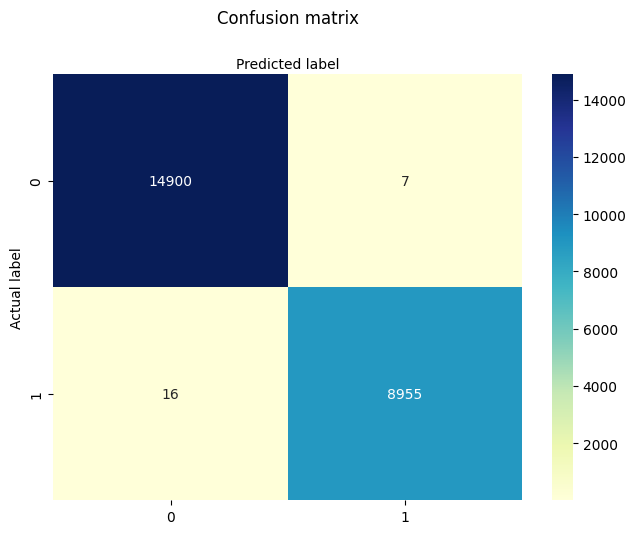

In [ ]:
from sklearn.model_selection import cross_val_score
X_train_mm = X1_train
X_test_mm = X1_test
y_train = Y1_train
y_test = Y1_test
#Logistic Regression
logreg = LogisticRegression(max_iter=500).fit(X_train_mm, y_train)
scores = cross_val_score(logreg, X_train_mm, y_train, cv=5)
logreg_pred = logreg.predict(X_test_mm)

get_results(y_test, logreg_pred)
get_confusion_matrix(confusion_matrix(y_test, logreg_pred))